In [3]:
!wget -O gebco_2024_sub_ice_topo.zip "https://www.bodc.ac.uk/data/open_download/gebco/gebco_2024_sub_ice_topo/zip/"

--2025-01-18 21:42:13--  https://www.bodc.ac.uk/data/open_download/gebco/gebco_2024_sub_ice_topo/zip/
Resolving www.bodc.ac.uk (www.bodc.ac.uk)... 192.171.196.106
Connecting to www.bodc.ac.uk (www.bodc.ac.uk)|192.171.196.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4422673961 (4.1G) [application/zip]
Saving to: ‘gebco_2024_sub_ice_topo.zip’

gebco_2024_sub_ice_ 100%[===================>]   4.12G  21.8MB/s    in 2m 14s  

2025-01-18 21:44:28 (31.4 MB/s) - ‘gebco_2024_sub_ice_topo.zip’ saved [4422673961/4422673961]



In [4]:
!unzip gebco_2024_sub_ice_topo.zip

Archive:  gebco_2024_sub_ice_topo.zip
  inflating: GEBCO_2024_sub_ice_topo.nc  
  inflating: GEBCO_Grid_Documentation.pdf  
  inflating: GEBCO_Grid_terms_of_use.pdf  


In [5]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [6]:
ds = xr.open_dataset('GEBCO_2024_sub_ice_topo.nc')
ds

<xarray.Dataset> Size: 7GB
Dimensions:    (lon: 86400, lat: 43200)
Coordinates:
  * lon        (lon) float64 691kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 346kB -90.0 -89.99 -89.99 ... 89.99 89.99 90.0
Data variables:
    crs        |S1 1B ...
    elevation  (lat, lon) int16 7GB ...
Attributes: (12/36)
    title:                           The GEBCO_2024 Grid - a continuous terra...
    summary:                         The GEBCO_2024 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/1c44ce99-0a0d-5f4f-e063-708...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/1c44ce99-0a0d-5f4f-e063-708...
    references:                      DOI: 10.5285/1c44ce99-0a0d-5f4f-e063-708...
    node_offset:                     1.0

In [9]:
ds.elevation.sizes['lat']

43200

In [29]:
nside=2048
chunk=1000
im=np.zeros([12*nside**2])
him=np.zeros([12*nside**2])
for k in range(0,ds.elevation.sizes['lat'],chunk):
    print(k)
    ed=k+chunk
    if ed>ds.elevation.sizes['lat']:
        ed=ds.elevation.sizes['lat']
    hidx = hp.ang2pix(
            nside,
            np.tile(ds.elevation.lon,ed-k),
            np.repeat(ds.elevation.lat[k:ed],ds.elevation.sizes['lon']),
            lonlat=True,
            nest=True,
        )
    im+=np.bincount(hidx,weights=ds.elevation[k:ed,:].values.flatten(),minlength=12*nside**2)
    him+=np.bincount(hidx,minlength=12*nside**2)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000


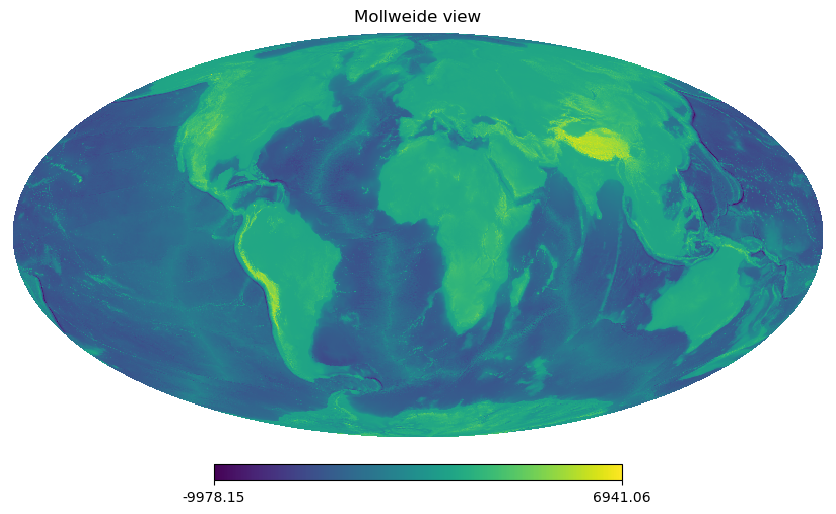

In [31]:
hp.write_map('GEBCO_%d.fits'%(nside)
hp.mollview(im/him,nest=True,flip='geo')

In [21]:

hidx = hp.ang2pix(
            nside,
            np.tile(ds.elevation.lon,ed-k),
            np.repeat(ds.elevation.lat[k:ed],ds.elevation.sizes['lon']),
            lonlat=True,
            nest=True,
        )
hidx.shape

(86400000,)

In [22]:
im=np.bincount(hidx,weights=ds.elevation[k:ed,:].values.flatten(),minlength=12*nside**2)
him=np.bincount(hidx,minlength=12*nside**2)

/tmp/ipykernel_9506/1846187063.py:1: RuntimeWarning: invalid value encountered in divide
  hp.gnomview(im/him,nest=True,rot=[0,-90])


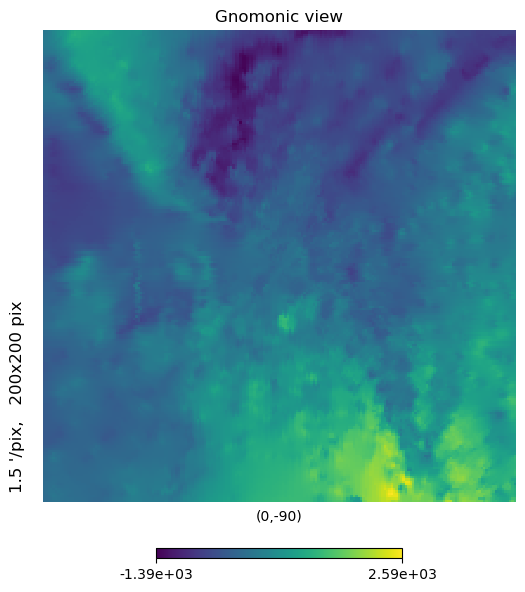

In [27]:
hp.gnomview(im/him,nest=True,rot=[0,-90])